# Module 2 Final Project
#### Kyle Johnson

In this project we will be working with the Northwind database to do hypothesis testing and will attempt to answer several business questions related to the fictional company:

- Do discounts increase quantity sold and if so, what is the optimal discount for increasing quantity?
- Do discounts increase revenue and if so,what is the optimal discount for increasing revenue?
- Do discounts increase the quantity sold for certain product groups?
- Do discounts increase revenue for certain product groups?
- Are any products more popular in their local markets than in foreign markets?
- Is there a "cheapest shipper" for each shipping route?

Below is the ERD visualization for the data that we will be working with.

<img src="Northwind_ERD.png">

In [222]:
# Importing the necessary libraries
import sqlite3 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from scipy import stats
import itertools 
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from datetime import datetime
# Connecting to the database
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()
# List of all tables
tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
tables = [i[0] for i in tables]
# Loop through all of the tables and put them into pandas dataframes
dfs = []
for i in tables:
    table = c.execute('select * from "'+i+'"').fetchall()
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
    foo = i+"_df"
    exec(foo + " = df")
    dfs.append(foo)

#### Initial Observations:
After exploring the data, it appears that for all products there have been two different "base unit prices" (there are a few with three).  All of the current unit prices are higher than their predecesors and the ratio of all of them is .8.  My guess is that there was a point in time at which base prices were raised 25% on all products.  Before diving into any analysis, I will demonstrate visually what I am referring to:

Text(0.5, 1.0, 'Current vs Previous Base Price')

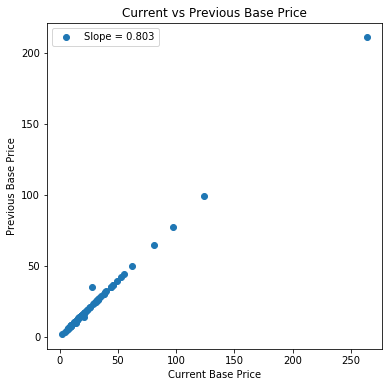

In [227]:
# Here I confirm and show that the base prices were all raised by the same amount accross all products
d=[]
n=[]
for i in range(1,78):
    x=OrderDetail_df[OrderDetail_df.ProductId==i]
    y=x.UnitPrice.unique()
    d.append(y[0])
    n.append(y[len(y)-1])
plt.figure(figsize=(6,6))
plt.scatter(n,d,label='Slope = '+str(round(np.mean(d)/np.mean(n),3)))
plt.xlabel('Current Base Price')
plt.ylabel('Previous Base Price')
plt.legend()
plt.title('Current vs Previous Base Price')

This knowledge will come in handy later on.

To answer some of the questions posed above, I will create a data frame by joining columns from three different data sets and calculating a few extra columns that will be used in this analysis.  I will then seperate the data into "current base price" and "previous base price" in order to visualize it.

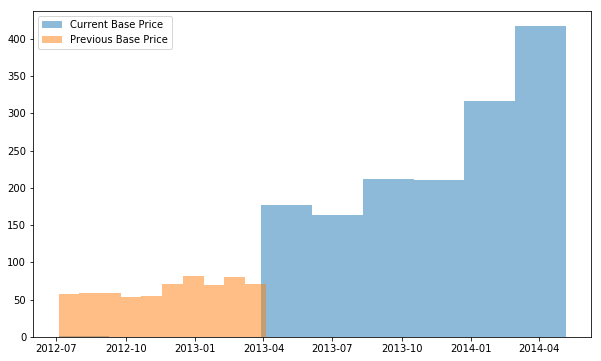

In [230]:
df1=pd.DataFrame([])
df1=pd.merge(OrderDetail_df,Product_df[['Id','UnitPrice','CategoryId']],left_on='ProductId',right_on='Id')
df1=pd.merge(df1,Order_df[['Id','OrderDate']],left_on='OrderId',right_on='Id')
df1['final_price']=df1['UnitPrice_x']*(1-df1['Discount'])
df1['final_price_pct_norm']=df1['final_price']/(df1['UnitPrice_y'])
df1['revenue']=df1['final_price']*(df1['Quantity'])
df1.OrderDate=pd.to_datetime(df1['OrderDate'])
current_base_price=df1[df1['UnitPrice_x']==df1['UnitPrice_y']]
old_base_price=df1[df1['UnitPrice_x']!=df1['UnitPrice_y']]
plt.figure(figsize=(10,6))
plt.hist(current_base_price.OrderDate,alpha=.5,label="Current Base Price")
plt.hist(old_base_price.OrderDate,alpha=.5,label="Previous Base Price")
plt.legend()

We can see that there was clearly a point in time around April of 2013 when there was a new pricing structure put in place.  Now we can move onto answering some of the questions from the beginning of the notebook.

## Question 1, Part A: Do discounts increase quantity sold?

$H_{0}$= The average quantity ordered is the same for orders with and without a discount. 

$H_{a}$= The average quantity ordered is greater for orders with discount.

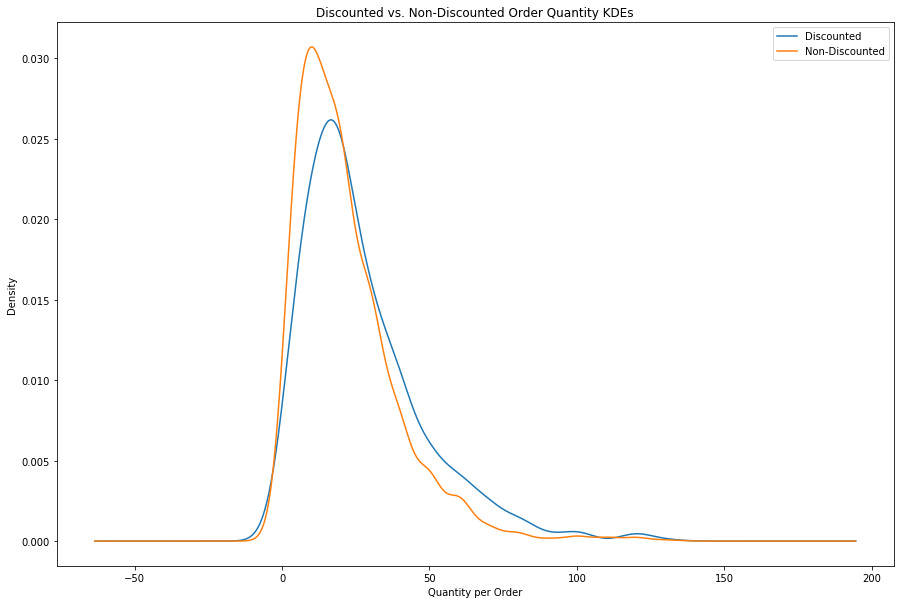

Coefficient:  6.239
p-value:  0.0


In [231]:
discounted=df1[df1['Discount']!=0]
not_discounted=df1[df1['Discount']==0]
plt.figure(figsize=(15, 10))
discounted.Quantity.plot.kde(label='Discounted')
not_discounted.Quantity.plot.kde(label='Non-Discounted')
plt.title('Discounted vs. Non-Discounted Order Quantity KDEs')
plt.xlabel('Quantity per Order')
plt.legend()
plt.show()
results = stats.ttest_ind(discounted.Quantity, not_discounted.Quantity, equal_var=False)
print('Coefficient: ',round(results[0],3))
print('p-value: ',round(results[1],3))

For a second type of analysis, we can compare order quantities when the end cost to the consumer is the same but sometimes as a result of a discount and sometimes as a result of the previous base price being lower.  Below is a visualization of overlapping populations that have the same dollar cost to the consumer.

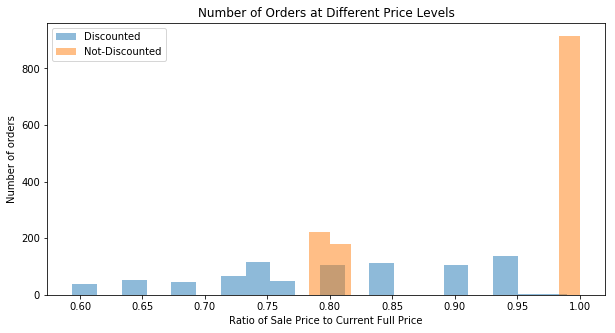

In [232]:
plt.figure(figsize=(10,5))
plt.hist(discounted.final_price_pct_norm,alpha=.5,bins=20,label="Discounted")
plt.hist(not_discounted.final_price_pct_norm,alpha=.5,bins=20,label="Not-Discounted")
plt.title('Number of Orders at Different Price Levels')
plt.xlabel('Ratio of Sale Price to Current Full Price')
plt.ylabel('Number of orders')
plt.legend()

We can see that there is a group around .80 that has some discounted and some not discounted.  Lets isolate these and compare them.

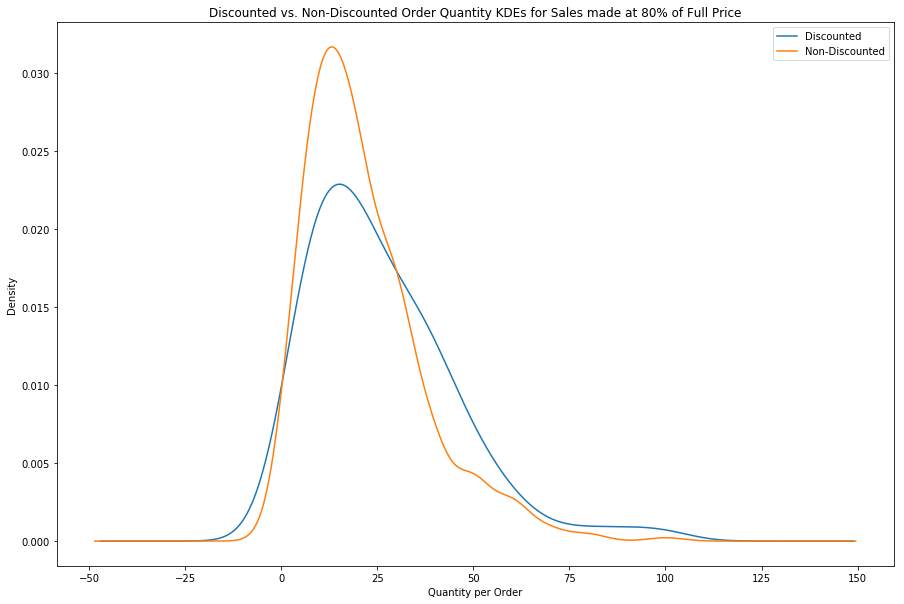

Coefficient:  2.337
p-value:  0.021


In [240]:
disc_eight=discounted[discounted['final_price_pct_norm']>.78]
disc_eight=disc_eight[disc_eight['final_price_pct_norm']<.82]
not_disc_eight=not_discounted[not_discounted['final_price_pct_norm']>.78]
not_disc_eight=not_disc_eight[not_disc_eight['final_price_pct_norm']<.82]
plt.figure(figsize=(15, 10))
disc_eight.Quantity.plot.kde(label='Discounted')
not_disc_eight.Quantity.plot.kde(label='Non-Discounted')
plt.title('Discounted vs. Non-Discounted Order Quantity KDEs for Sales made at 80% of Full Price')
plt.xlabel('Quantity per Order')
plt.legend()
plt.show()
results = stats.ttest_ind(disc_eight.Quantity, not_disc_eight.Quantity, equal_var=False)
print('Coefficient: ',round(results[0],3))
print('p-value: ',round(results[1],3))

When comparing the entire population, we see that the coefficient is greater zero, and the p-value is less than .05.  When isolating by the price paid by the consumer, the coefficient is still positive and significant. This means that we can reject the null hypothesis and thus conclude that discounts have an effect on the quantity of units sold per order by an average of 6.2 units per order for the whole population.

## Question 1, Part B: What levels of discount increases quantity sold?
$H_{0}$= The average quantity ordered is the same for all levels of discount. 

$H_{a}$= The average quantity ordered is different for different levels of discount.

I will only examine discount values of 5%, 10%, 15%, 20% and 25% because they have significant amounts of data points.

,Discount,Stat,pvalue
0,0.05,0.637,0.525
1,0.10,-1.312,0.191
2,0.15,0.847,0.398
3,0.20,-0.062,0.951
4,0.25,0.766,0.444


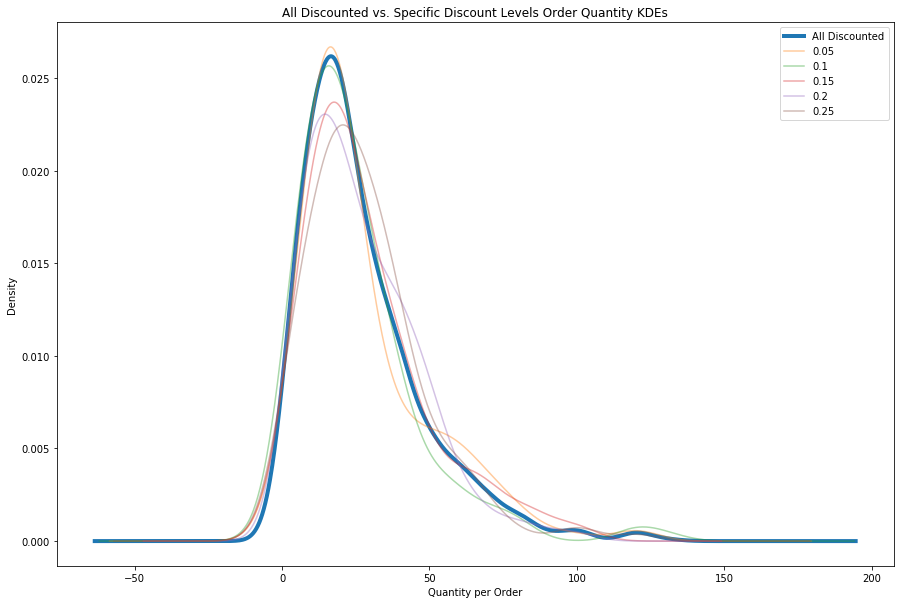

In [237]:
discount_amounts=[.05,.1,.15,.2,.25]
discount_levels_quantity=pd.DataFrame([])
plt.figure(figsize=(15, 10))
discounted.Quantity.plot.kde(label='All Discounted',linewidth=4)
for i in discount_amounts:
    x=discounted[discounted['Discount']==i]
    y=discounted[discounted['Discount']!=i]
    x.Quantity.plot.kde(label=i,alpha=.4)
    results = stats.ttest_ind(x.Quantity, y.Quantity, equal_var=False)
    discount_levels_quantity=discount_levels_quantity.append(pd.DataFrame({'Discount':i,
                                                                           'Stat':round(results[0],3),
                                                                           'pvalue':round(results[1],3)},
                                                                          index=[0]),ignore_index=True)
plt.legend()
plt.title('All Discounted vs. Specific Discount Levels Order Quantity KDEs')
plt.xlabel('Quantity per Order')
discount_levels_quantity

From the table we can see that none of the discount amounts has a mean that is different from the rest of the discounted population in a statically significant way.  This means that we must accept the null hypothesis that the average quantity ordered is the same for all levels of discount.

## Question 2, Part A: Do discounts increase revenue?

$H_{0}$= The average revenue is the same for orders with and without a discount. 

$H_{a}$= The average revenue is greater for orders with discount.

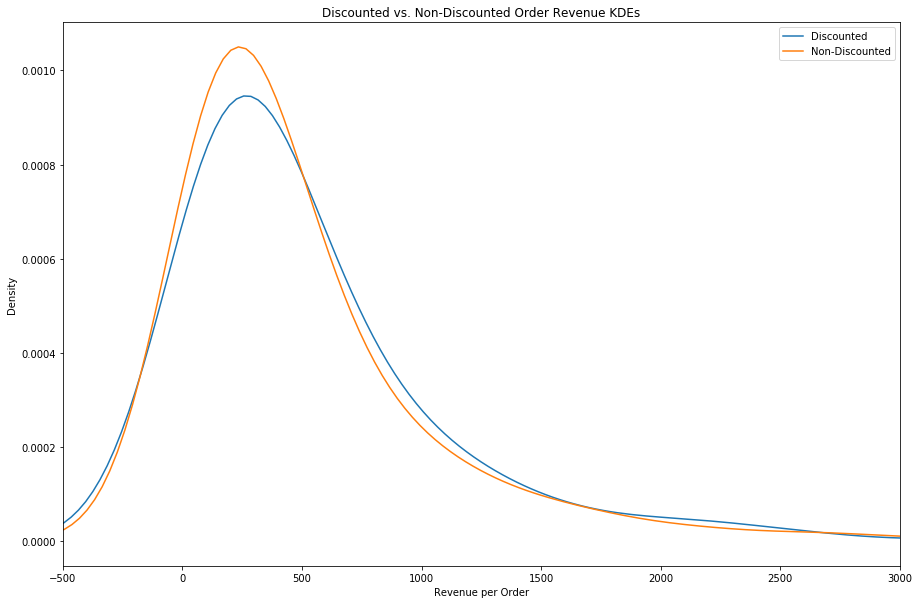

Coefficient:  1.038
p-value:  0.299


In [238]:
discounted=df1[df1['Discount']!=0]
not_discounted=df1[df1['Discount']==0]
plt.figure(figsize=(15, 10))
discounted.revenue.plot.kde(label='Discounted')
not_discounted.revenue.plot.kde(label='Non-Discounted')
plt.title('Discounted vs. Non-Discounted Order Revenue KDEs')
plt.xlabel('Revenue per Order')
plt.xlim(-500,3000)
plt.legend()
plt.show()
results = stats.ttest_ind(discounted.revenue, not_discounted.revenue, equal_var=False)
print('Coefficient: ',round(results[0],3))
print('p-value: ',round(results[1],3))

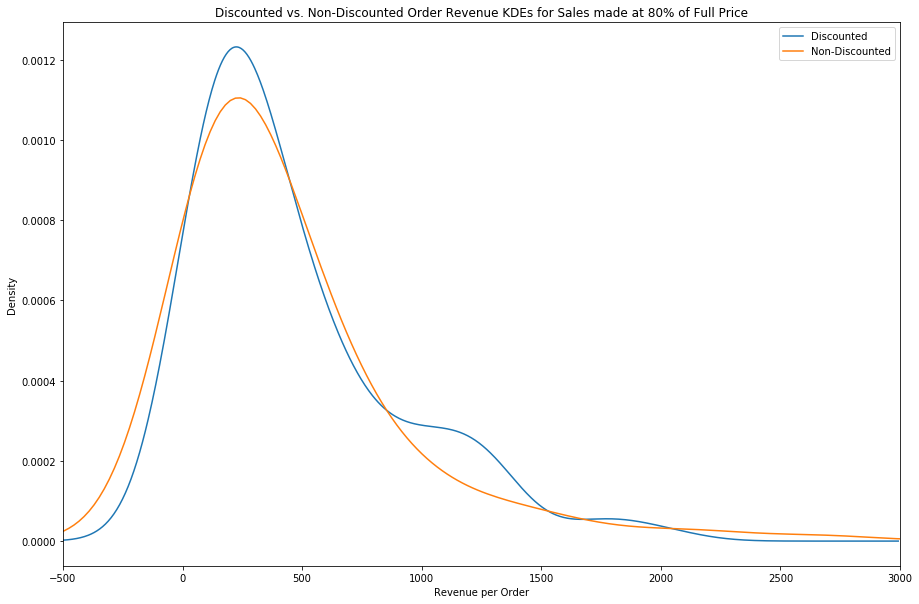

Coefficient:  -0.24250537562694735
p-value:  0.808553800062787


In [241]:
plt.figure(figsize=(15, 10))
disc_eight.revenue.plot.kde(label='Discounted')
not_disc_eight.revenue.plot.kde(label='Non-Discounted')
plt.title('Discounted vs. Non-Discounted Order Revenue KDEs for Sales made at 80% of Full Price')
plt.xlabel('Revenue per Order')
plt.xlim(-500,3000)
plt.legend()
plt.show()
results = stats.ttest_ind(disc_eight.revenue, not_disc_eight.revenue, equal_var=False)
print('Coefficient: ',results[0])
print('p-value: ',results[1])

In both the enitre population and the population isolated by price paid by the consumer, the p-value is greater than .05 and thus we cannot reject the null hypothesis.  This is useful business intellegence because if discounts are increasing order size but not increasing revenue, profits will presumably decrease on orders with a discount. 

## Question 2, Part B: What levels of discount increases revenue?
$H_{0}$= The average revenue is the same for all levels of discount. 

$H_{a}$= The average revenue is different for different levels of discount.

In this case I will set up the population comparison slightly differently because discounts as a whole do not increase revenue.  I will compare each level of discount to the not-discounted population.

,Discount,Stat,pvalue
0,0.05,2.091,0.038
1,0.10,-0.799,0.425
2,0.15,-0.237,0.813
3,0.20,-0.197,0.844
4,0.25,0.860,0.391


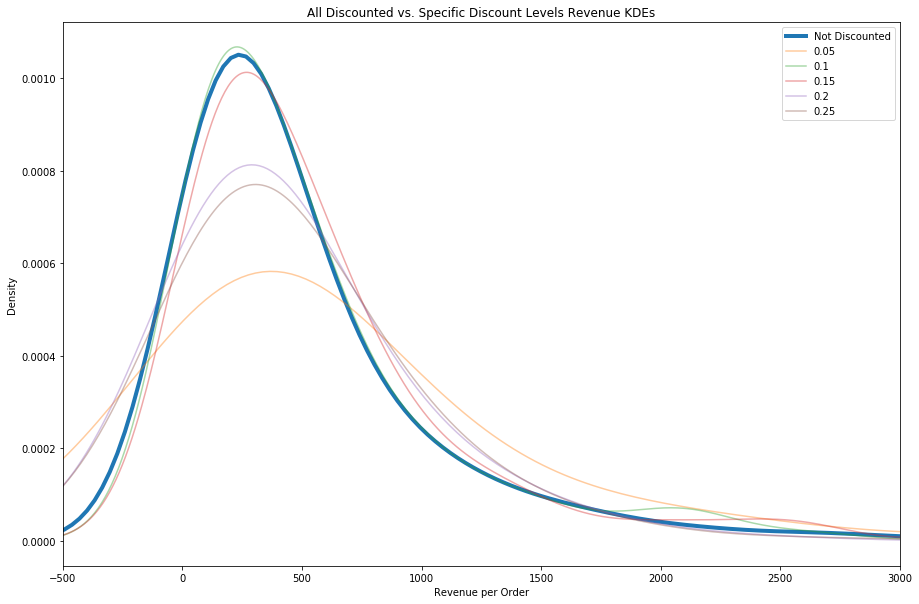

In [242]:
discount_levels_revenue=pd.DataFrame([])
plt.figure(figsize=(15, 10))
not_discounted.revenue.plot.kde(label='Not Discounted',linewidth=4)
for i in discount_amounts:
    x=discounted[discounted['Discount']==i]
    y=not_discounted
    x.revenue.plot.kde(label=i,alpha=.4)
    results = stats.ttest_ind(x.revenue, y.revenue, equal_var=False)
    discount_levels_revenue=discount_levels_revenue.append(pd.DataFrame({'Discount':i,
                                                                         'Stat':round(results[0],3),
                                                                         'pvalue':round(results[1],3)},
                                                                        index=[0]),ignore_index=True)
plt.legend()
plt.title('All Discounted vs. Specific Discount Levels Revenue KDEs')
plt.xlabel('Revenue per Order')
plt.xlim(-500,3000)
discount_levels_revenue

Here we see that we can only reject the null hypothesis for the 5% discount level.  A discount of 5% will increase the average order's revenue by $2.09.  From a business desicion making point of view, this must be weighted against the increased cost of the discount in terms of additional units provided to the customer.

## Question 3: Do discounts increase the quantity sold for certain product groups?

$H_{0}$= The average quantity ordered is the same for all levels of discount. 

$H_{a}$= The average quantity ordered is different for different levels of discount.

In [198]:
cats=[1,2,3,4,5,6,7]
category_quantity=pd.DataFrame([])
for i in cats:
    w=df1[df1.CategoryId==i]
    x=w[w['Discount']!=0]
    y=w[w['Discount']==0]
    results = stats.ttest_ind(x.Quantity, y.Quantity, equal_var=False)
    category_quantity=category_quantity.append(pd.DataFrame({'Category':Category_df.CategoryName[i],
                                                             'Stat':round(results[0],3),
                                                             'pvalue':round(results[1],3)},
                                                            index=[0]),ignore_index=True)
category_quantity

,Category,Stat,pvalue
0,Condiments,3.484,0.001
1,Confections,2.745,0.007
2,Dairy Products,0.763,0.446
3,Grains/Cereals,3.544,0.000
4,Meat/Poultry,0.597,0.551
5,Produce,2.343,0.021
6,Seafood,0.838,0.405


Here we see that Condiments, Confections, Grains/Cereals and Produce have a p-value of less than .05, thus we can reject the null hypothesis in those cases and conclude that discounts increase the average order quantity by 3.5, 2.7, 3.5 and 2.3 units respectively.

## Question 4: Do discounts increase the revenue for certain product groups?

$H_{0}$= The average revenue is the same for all levels of discount. 

$H_{a}$= The average revenue is different for different levels of discount.

In [199]:
cats=[1,2,3,4,5,6,7]
category_revenue=pd.DataFrame([])
for i in cats:
    w=df1[df1.CategoryId==i]
    x=w[w['Discount']!=0]
    y=w[w['Discount']==0]
    results = stats.ttest_ind(x.revenue, y.revenue, equal_var=False)
    category_revenue=category_revenue.append(pd.DataFrame({'Category':Category_df.CategoryName[i],
                                                           'Stat':round(results[0],3),
                                                           'pvalue':round(results[1],3)},
                                                          index=[0]),ignore_index=True)
category_revenue

,Category,Stat,pvalue
0,Condiments,0.601,0.549
1,Confections,1.088,0.278
2,Dairy Products,-1.299,0.195
3,Grains/Cereals,1.180,0.239
4,Meat/Poultry,-0.358,0.721
5,Produce,0.340,0.734
6,Seafood,0.732,0.467


In this case again we see that none of the results are statistically significant and thus we must accept the null hypothesis that the average revenue is the same for all levels of discounts accross all product groups.  This gives further strength to the conclusion that offering discounts will likely decrease profits.

## Question 5: Are any products more popular in their local markets than in foreign markets?

For this question I will use the average order revenue as a proxy for popularity and use the term "local" to describe orders of products being delivered to the same region as the item was produced.

$H_{0}$= The average revenue is the same in the local market as in the foriegn market. 

$H_{a}$= The average revenue is different different in the local market than in the foriegn market.

To do this, I will make a new data frame by combining the necessary data points.

In [200]:
df2=pd.merge(OrderDetail_df,Product_df,left_on='ProductId',right_on='Id')
df2=pd.merge(df2,Supplier_df,left_on='SupplierId',right_on='Id')
df2=pd.merge(df2,Order_df,left_on='OrderId',right_on='Id')
df2['revenue']=df2['UnitPrice_x']*(1-df2['Discount'])*(df2['Quantity'])
product_results=pd.DataFrame([])
for i in range(0,76):
    prod=df2[df2['ProductId']==i+1]
    prod_y=prod[prod['Region']==prod['ShipRegion']]
    prod_n=prod[prod['Region']!=prod['ShipRegion']]
    results = stats.ttest_ind(prod_y.revenue, prod_n.revenue, equal_var=False)
    if prod_y.shape[0]>1 and prod_n.shape[0]>1:
        product_results=product_results.append(pd.DataFrame({'Product':Product_df.ProductName[i+1],
                                                             'Local':prod_y.shape[0],
                                                             'Foriegn':prod_n.shape[0],
                                                             'Coefficient':round(results[0],3),
                                                             'pvalue':round(results[1],3)},
                                                            index=[0]),ignore_index=True)
    else: None
product_results[product_results['pvalue']<.05]

C:\Users\kylej\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\kylej\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\kylej\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\kylej\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\kylej\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,Product,Local,Foriegn,Coefficient,pvalue
8,Gustaf's Knäckebröd,2,37,-3.223,0.011
23,Chocolade,4,17,2.219,0.048
26,Ravioli Angelo,5,45,-2.517,0.034
29,Camembert Pierrot,18,36,2.179,0.039
30,Sirop d'érable,15,36,2.546,0.019
34,Louisiana Hot Spiced Okra,3,29,-2.442,0.022
35,Scottish Longbreads,2,8,-3.812,0.007


We can see that of all 77 products, only 7 of them have a statistically significant difference in the average order revenue between local and foriegn markets.  Interestingly, several of the coefficients are negative, meaning that the item is "more popular" outside of its local market.

## Question 6: Do any regions, in aggregate, produce products that are more popular in their local markets than in foreign markets?

$H_{0}$= The average revenue is the same in the local market as in the foriegn market. 

$H_{a}$= The average revenue is different different in the local market than in the foriegn market.

In [201]:
Regions=['Western Europe','North America','Southern Europe',
         'British Isles','Scandinavia','Victoria',
         'Northern Europe','Eastern Asia','NSW',
         'South-East Asia','South America']
data_regions=pd.DataFrame([])
for i in Regions:
    prod=df2[df2['Region']==i]
    prod_y=prod[prod['Region']==prod['ShipRegion']]
    prod_n=prod[prod['Region']!=prod['ShipRegion']]
    results = stats.ttest_ind(prod_y.revenue, prod_n.revenue, equal_var=False)
    if prod_y.shape[0]>1 and prod_n.shape[0]>1:
        data_regions=data_regions.append(pd.DataFrame({'Region':i,'Local':prod_y.shape[0],
                                                       'Foriegn':prod_n.shape[0],
                                                       'Coefficient':round(results[0],3),
                                                       'pvalue':round(results[1],3)},
                                                      index=[0]),ignore_index=True)
    else: None
data_regions

,Region,Local,Foriegn,Coefficient,pvalue
0,Western Europe,152,295,1.664,0.097
1,North America,90,328,1.575,0.118
2,Southern Europe,12,217,-0.512,0.617
3,British Isles,16,204,0.779,0.448
4,Scandinavia,7,168,-0.550,0.597
5,Northern Europe,13,140,0.006,0.995
6,South America,9,42,-0.148,0.884


Here we can see that none of the results are statistically significant and thus we cannot reject the null hypothesis for any region.

## Question 7: Is a particular shipper less expensive than the others?
To answer this questions we must acknowledge the many limitations given the data set.  Information such as package size/weight, distance of delivery and delivery time are unavailable and thus any results should be taken with a large grain of salt.

$H_{0}$= The average freight cost is equal among all shippers. 

$H_{a}$= The average freight cost is not equal among all shippers.

,Shipper,Coefficiet,pvalue
0,Speedy Express,-4.293,0.000
1,United Package,2.636,0.008
2,Federal Shipping,0.485,0.628


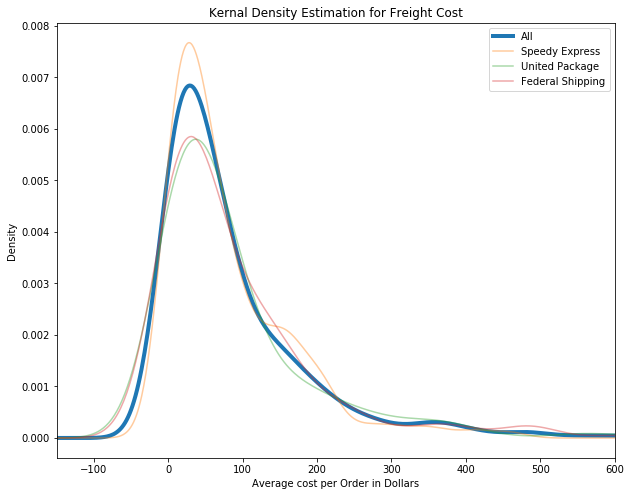

In [243]:
df5=pd.merge(OrderDetail_df,Order_df[['Id','ShipVia','Freight','ShipRegion']],left_on='OrderId',right_on='Id')
shippers=pd.DataFrame([])
plt.figure(figsize=(10, 8))
df5.Freight.plot.kde(label='All',linewidth=4)
for i in [1,2,3]:
    x=df5[df5['ShipVia']==i]
    y=df5[df5['ShipVia']!=i]
    x.Freight.plot.kde(label=Shipper_df.CompanyName[i-1],alpha=.4)
    results = stats.ttest_ind(x.Freight, y.Freight, equal_var=False)
    shippers=shippers.append(pd.DataFrame({'Shipper':Shipper_df.CompanyName[i-1],'Coefficiet':round(results[0],3),
                                           'pvalue':round(results[1],3)},index=[0]),ignore_index=True)
plt.title('Kernal Density Estimation for Freight Cost')
plt.xlabel('Average cost per Order in Dollars')
plt.legend()
plt.xlim(-150,600)
shippers

Speedy Express and United Package both have a p-value less than .05 and thus their results are statistically significant.  Speedy Express is 4.29 cheaper per package than average and United Package is 2.63 more expensive than average.  These results are still misleading since there are so many variables still at play.  Lets dive deeper by doing this same analysis for each region that the order is shipped to.

In [244]:
for i in Regions:
    shipper_region=pd.DataFrame([])
    w=df5[df5['ShipRegion']==i]
    count=0
    for j in [1,2,3]:
        x=w[w['ShipVia']==j]
        y=w[w['ShipVia']!=j]
        if x.shape[0]>1 and y.shape[0]>1:
            count+=1
            results = stats.ttest_ind(x.Freight, y.Freight, equal_var=False)
            shipper_region=shipper_region.append(pd.DataFrame({'Shipper':Shipper_df.CompanyName[j-1],
                                                                         'Coefficiet':round(results[0],3),
                                                                         'pvalue':round(results[1],3)},
                                                                        index=[0]),ignore_index=True)
        else: None
    if count==3:
        print(i)
        print(shipper_region)
        print('')

Western Europe
            Shipper  Coefficiet  pvalue
0    Speedy Express      -1.275   0.203
1    United Package      -0.669   0.504
2  Federal Shipping       1.794   0.074

North America
            Shipper  Coefficiet  pvalue
0    Speedy Express      -3.685   0.000
1    United Package       0.208   0.836
2  Federal Shipping       1.879   0.061

Southern Europe
            Shipper  Coefficiet  pvalue
0    Speedy Express      -2.100   0.038
1    United Package       3.075   0.003
2  Federal Shipping      -1.883   0.062

British Isles
            Shipper  Coefficiet  pvalue
0    Speedy Express      -0.765   0.446
1    United Package       2.001   0.048
2  Federal Shipping      -2.037   0.043

Scandinavia
            Shipper  Coefficiet  pvalue
0    Speedy Express      -2.208   0.032
1    United Package       4.472   0.000
2  Federal Shipping      -3.744   0.000

Northern Europe
            Shipper  Coefficiet  pvalue
0    Speedy Express      -1.377   0.172
1    United Package       4.

To interpret these results we must only consider coefficients whose p-value is less than .05. In doing this we find that Speedy Express is cheaper when shipping to North America, Sounthern Europe, Scandinavia and South America; United Package is more expensive when shipping to Southern Europe, British Isles, Scandinavia, Northern Europe, and South America; Federal Shipping is cheaper when shipping to the British Isles, Scandinavia and Northern Europe.  All in all, this seems to confirm our findings above that Speedy Express is less expensive and United Package is more expensive.

# Conclusions:
1) The company should not offer discounts because discounts almost certainly are leading to a reduction in profit.  This stems from the following:
- Discounts do increase the quantity of units sold in an order and no particular level of discount is supperior.
- Discounts do not increase the revenue per order, except for the 5% discount level which leads to a revenue increase of just over 2 dollars.
- This strongly suggests that discounts simply lead to customers spending the same amount of money while getting more of the product, meaning that the company is effectively just reducing its selling price and thus reducing its profit margin.

2) Speedy Express is the cheapest shipper and should be used whenever possible if other characteristics such as time to delivery are the same.


# Further Inquiry:
I recommend that in order to gain more useful insight for the company, that metrics on advertising and competition be obtained and studied.